In [1]:
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

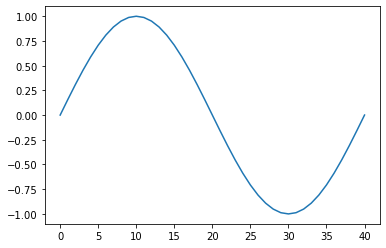

In [2]:
plt.plot(y[:41])
plt.show()

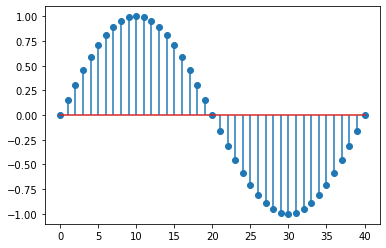

In [3]:
plt.stem(y[:41])
plt.show()

```
$ mkdir -p ~/aiffel/speech_recognition/data
$ mkdir -p ~/aiffel/speech_recognition/models
$ wget http://bigfile.mail.naver.com/bigfileupload/download?fid=8QbZaAIq1NKXFoMjK3YXaxbwF3YZKAUmKxgwaxulFAMqFCYwFog9FquwFxvlHrMrpxg9KAtwFAt9K6K9F4udpx0oKxFvKxCoFq+vpo+0 -O speech_wav_8000.npz
$ mv speech_wav_8000.npz ~/aiffel/speech_recognition/data
```

In [4]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [5]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [6]:
import IPython.display as ipd
import random

# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  15383
Wave data shape :  (8000,)
label :  ['stop']


In [7]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
print("✅")

✅


In [8]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print("✅")

✅


In [9]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 1.9681093e-03  4.0165000e-03  4.3621138e-03 ... -3.5547570e-03
  -3.6639993e-03 -4.7142538e-03]
 [ 1.5371372e-03  1.8624262e-03  1.9701379e-03 ...  3.1180053e-03
   3.2218434e-03  2.9762813e-03]
 [ 3.7728897e-03  5.4353722e-03 -2.0761427e-04 ...  3.0444989e-03
   3.2046535e-03 -2.3672509e-03]
 ...
 [ 3.3191594e-03  4.7447789e-03  7.0606126e-05 ...  2.8148228e-03
   2.8505982e-03 -2.0946851e-03]
 [ 3.3186926e-03  4.7435132e-03  8.5089443e-05 ...  2.4560117e-03
   2.0492449e-03 -1.7966374e-03]
 [ 3.2938970e-03  4.7343206e-03  8.2666957e-05 ...  2.5966146e-03
   2.0862829e-03 -1.8218176e-03]]
✅


In [10]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


In [11]:
batch_size = 128
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

In [12]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [13]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [14]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)         

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [17]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.5108 - accuracy: 0.4933
Epoch 00001: val_loss improved from inf to 1.24579, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 140s 394ms/step - loss: 1.5108 - accuracy: 0.4933 - val_loss: 1.2458 - val_accuracy: 0.6162
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.8526 - accuracy: 0.7370
Epoch 00002: val_loss improved from 1.24579 to 0.77055, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 144s 407ms/step - loss: 0.8526 - accuracy: 0.7370 - val_loss: 0.7705 - val_accuracy: 0.7622
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.8160
Epoch 00003: val_loss improved from 0.77055 to 0.62281, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 148s 416ms/step - loss: 0.6244 - accu

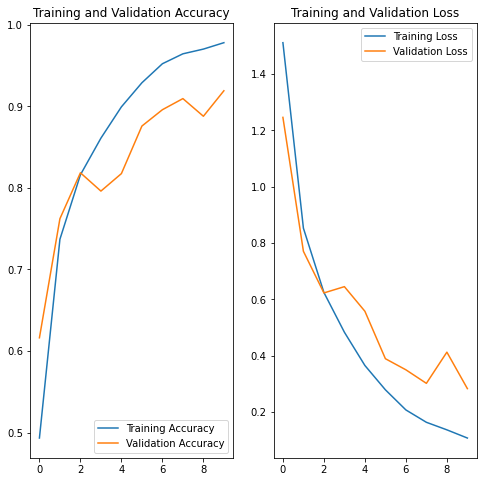

✅


In [18]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [19]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [20]:
results = model_wav.evaluate(test_dataset)
print("✅")

40/40 [==============================] - 7s 183ms/step - loss: 0.2851 - accuracy: 0.9184
✅


In [21]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.285
accuracy value: 91.8412%
✅


In [22]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  unknown


In [23]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: unknown
✅


In [24]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
_______________________________________________________________________________________

In [25]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [26]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [27]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.3236 - accuracy: 0.5735
Epoch 00001: val_loss improved from inf to 1.21208, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 170s 480ms/step - loss: 1.3236 - accuracy: 0.5735 - val_loss: 1.2121 - val_accuracy: 0.6917
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.7248 - accuracy: 0.7885
Epoch 00002: val_loss improved from 1.21208 to 0.81350, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 169s 476ms/step - loss: 0.7248 - accuracy: 0.7885 - val_loss: 0.8135 - val_accuracy: 0.7392
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.8684
Epoch 00003: val_loss improved from 0.81350 to 0.59104, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 168s 473ms/step - loss

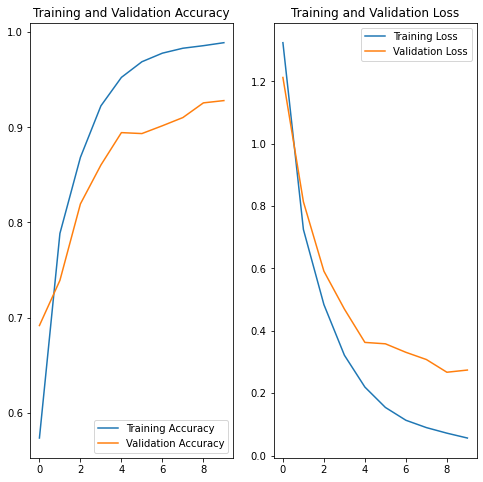

✅


In [28]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [29]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

40/40 [==============================] - 6s 145ms/step - loss: 0.2677 - accuracy: 0.9255
loss value: 0.268
accuracy value: 92.5524%
✅


In [30]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  right


In [31]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: right
✅


```
$ pip install librosa
```

In [32]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [33]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


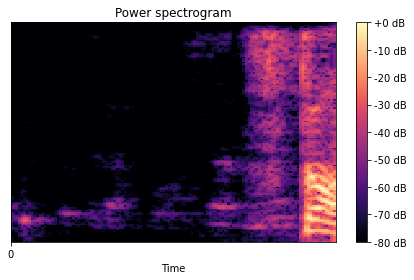

In [34]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()